In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

root_dir = '/content/gdrive/MyDrive/Data'

Mounted at /content/gdrive


In [2]:
import os
import random
import shutil
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import csv
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import RMSprop
from pandas.core.frame import DataFrame
from time import sleep


Downsampling preprocessing's dataset

In [ ]:
data_loading_dir = os.path.join(root_dir, "18 participants/AX3/Preprocessed")
data_saving_dir = os.path.join(root_dir, "18 participants/AX3/DownsampledDataset")

def downsample(dataset):
  newDataset = pd.DataFrame()
  newDataset["Label"] = dataset["Label"]
  newDataset["X1"] = dataset["X"].apply(lambda x : np.mean(np.array(x[:1500])))
  newDataset["X2"] = dataset["X"].apply(lambda x : np.mean(np.array(x[1500:])))
  newDataset["Y1"] = dataset["Y"].apply(lambda x : np.mean(np.array(x[:1500])))
  newDataset["Y2"] = dataset["Y"].apply(lambda x : np.mean(np.array(x[1500:])))
  newDataset["Z1"] = dataset["Z"].apply(lambda x : np.mean(np.array(x[:1500])))
  newDataset["Z2"] = dataset["Z"].apply(lambda x : np.mean(np.array(x[1500:])))
  newDataset["Temp"] = dataset["Temp"].apply(lambda x : np.mean(np.array(x)))
  newDataset["Activity"] = dataset["Activity"]
  dataset = None
  sleep(60)
  return newDataset

In [ ]:
participants = 18

for participant in range(1, participants+1):
  file_name = os.path.join(data_loading_dir, "AX3_step1_sub" + str(participant) + ".pkl")
  save_name = os.path.join(data_saving_dir, "Dataset_participant" + str(participant) + ".pkl")
  dataset = pd.read_pickle(file_name)  
  newDataset = downsample(dataset)
  newDataset.to_pickle(save_name)
  dataset = None
  sleep(60)


Data transformation

In [ ]:
data_loading_dir = os.path.join(root_dir, "18 participants/AX3/DownsampledDataset")
file_name = os.path.join(data_loading_dir, "Dataset_participant1.pkl")
participants = 18
experience = 1
orig_dataset = pd.read_pickle(file_name)

for participant in range(2, participants + 1):
  file_name = os.path.join(data_loading_dir, "Dataset_participant" + str(participant) + ".pkl")
  new_dataset = pd.read_pickle(file_name)
  orig_dataset = orig_dataset.append(new_dataset, ignore_index=True)

data_saving_dir = os.path.join(root_dir, "18 participants/AX3/TransformedData" + str(experience))
if not os.path.exists(data_saving_dir):
  os.mkdir(data_saving_dir)

save_file = os.path.join(data_saving_dir, "Raw.pkl")
orig_dataset.to_pickle(save_file)

In [3]:
from scipy.fft import fft

def perm(orig_dataset):
  dataset = orig_dataset.drop(['Label'], axis=1)
  columns = np.array(dataset.columns)
  randIdx = random.sample(range(0, len(columns)),len(columns))
  new_columns = []
  for i in range(len(columns)):
    new_columns.append(columns[randIdx[i]])
  dataset.columns = (new_columns)
  for i in range(len(columns)):
    column = new_columns[i]
    dataset[column] = orig_dataset[column]
  return dataset

def noise(orig_dataset):
  dataset = orig_dataset.drop(['Label'], axis=1)
  stds = np.array(orig_dataset.std())
  columns = dataset.columns
  for i in range(len(columns)):
    std_val = stds[i] / 10
    column = columns[i]
    mean = dataset[column].mean()
    dataset['std'] = pd.DataFrame(np.random.normal(mean, std_val, (orig_dataset.shape[0],1)))
    dataset[column] = dataset[column] + dataset['std']
  dataset = dataset.drop(['std'], axis=1)
  #print(dataset.head(3))
  return dataset

def FFT(orig_dataset):
  dataset = orig_dataset.drop(['Label'], axis=1)
  columns = dataset.columns
  for i in range(len(columns)):
    column = columns[i]
    dataset[column] = fft(np.array(dataset[column]))
  return dataset

In [32]:
experience = 1
numberOfClasses = 4
data_loading_dir = os.path.join(root_dir, "18 participants/AX3/TransformedData" + str(experience))
load_file = os.path.join(data_loading_dir, "Raw.pkl")
orig_dataset = pd.read_pickle(load_file)

permuted_dataset = perm(orig_dataset)
noised_dataset = noise(orig_dataset)
fft_dataset = FFT(orig_dataset)
raw_dataset = orig_dataset.drop(['Label'], axis=1)

def SaveFile(dataset, file_name):
  save_file = os.path.join(data_loading_dir, file_name + ".pkl")
  dataset.to_pickle(save_file)

def getLabel(label, length):
  data = {}
  for i in range(len(label)):
    data[i] = np.full(length,label[i])
  dataset = DataFrame(data)
  return dataset

def countNans(dataset):
  counts = 0
  columns = dataset.columns
  for i in range(len(columns)):
    column = columns[i]
    counts = counts + dataset[column].isnull().sum()
  return counts

def getLabelsDataset(numberOfClasses, length):
  label = np.zeros(numberOfClasses)
  label[0] = 1
  dataset = getLabel(label, length)
  for i in range(1, numberOfClasses):
    label = np.zeros(numberOfClasses)
    label[i] = 1
    new_dataset = getLabel(label, length)
    dataset = dataset.append(new_dataset, ignore_index=True)
    new_dataset = None
  return dataset

def windowDataset(dataset, window_size):
  new_dataset = []
  for i in range(0,dataset.shape[0], window_size):
    value = dataset[i]
    for j in range(i+1, i+window_size):
      value = np.append(value, dataset[j], axis=0)
    new_dataset.append(value)
  return np.array(new_dataset)

def windowLabels(dataset, window_size):
  new_labels = []
  for i in range(0, labels.shape[0], window_size):
    new_labels.append(labels[i])
  return np.array(new_labels)

def get_train_test_splits(dataset, spare_label, numberOfClasses):
  label = np.zeros(numberOfClasses)
  label[spare_label] = 1
  labels = getLabel(label, dataset.shape[0])
  dataset = np.array(dataset)
  n = dataset.shape[0]
  train_ratio = 0.9
  separate_id = int(n * train_ratio)

  x_train = dataset[:separate_id]
  y_train = labels[:separate_id]

  x_test = dataset[separate_id:]
  y_test = labels[separate_id:]
  return x_train, y_train, x_test, y_test

SaveFile(permuted_dataset, "Permuted")
SaveFile(noised_dataset, "Noised")
SaveFile(fft_dataset, "FFT")

#merged_dataset = None
#merged_dataset = pd.concat([merged_dataset, raw_dataset])
#merged_dataset = pd.concat([merged_dataset, permuted_dataset])
#merged_dataset = pd.concat([merged_dataset, noised_dataset])
#merged_dataset = pd.concat([merged_dataset, fft_dataset])
#merged_dataset = merged_dataset.reset_index()
#SaveFile(merged_dataset, "Merged")
#print(merged_dataset.shape)

labels = getLabelsDataset(4, permuted_dataset.shape[0])
SaveFile(labels, "Labels")


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


In [24]:
experience = 1
numberOfClasses = 4
data_loading_dir = os.path.join(root_dir, "18 participants/AX3/TransformedData" + str(experience))
load_file = os.path.join(data_loading_dir, "Merged.pkl")
#dataset = np.array(pd.read_pickle(load_file))
#dataset = pd.read_pickle(load_file).drop('index', axis=1)
#dataset = np.array(dataset)

#print(countNans(raw_dataset))
#print(countNans(permuted_dataset))
#print(countNans(noised_dataset))
#print(countNans(fft_dataset))

#dataset = np.array(raw_dataset)
#dataset = np.append(dataset, np.array(permuted_dataset), axis=0)
#dataset = np.append(dataset, np.array(noised_dataset), axis=0)
#dataset = np.append(dataset, np.array(fft_dataset), axis=0)

x_train, y_train, x_test, y_test = get_train_test_splits(raw_dataset, 0, numberOfClasses)
new_x_train, new_y_train, new_x_test, new_y_test = get_train_test_splits(permuted_dataset, 1, numberOfClasses)
x_train = np.append(x_train, new_x_train, axis=0)
y_train = np.append(y_train, new_y_train, axis=0)
x_test = np.append(x_test, new_x_test, axis=0)
y_test = np.append(y_test, new_y_test, axis=0)

new_x_train, new_y_train, new_x_test, new_y_test = get_train_test_splits(noised_dataset, 2, numberOfClasses)
x_train = np.append(x_train, new_x_train, axis=0)
y_train = np.append(y_train, new_y_train, axis=0)
x_test = np.append(x_test, new_x_test, axis=0)
y_test = np.append(y_test, new_y_test, axis=0)

new_x_train, new_y_train, new_x_test, new_y_test = get_train_test_splits(fft_dataset, 3, numberOfClasses)
x_train = np.append(x_train, new_x_train, axis=0)
y_train = np.append(y_train, new_y_train, axis=0)
x_test = np.append(x_test, new_x_test, axis=0)
y_test = np.append(y_test, new_y_test, axis=0)

x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1, 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1, 1))

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(1855368, 8, 1, 1)
(1855368, 4)
(206152, 8, 1, 1)
(206152, 4)


In [25]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
#create model
model = Sequential()
#add model layers
model.add(Conv2D(8, kernel_size=(1,1), activation='relu', input_shape=(8,1,1)))

model.add(Flatten())
model.add(Dense(6, activation='relu'))
model.add(Dense(4, activation='softmax'))
#print(model.summary())

In [26]:
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
sgd = SGD(learning_rate=0.001)
rms = RMSprop(learning_rate=0.0001)
adam = Adam(learning_rate=0.001, epsilon=0.1)
model.compile(optimizer=adam,
                loss='categorical_crossentropy',
                metrics=['accuracy'])

model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=5)

Epoch 1/5
57981/57981 [==============================] - 131s 2ms/step - loss: 0.4975 - accuracy: 0.7969 - val_loss: 1.0191 - val_accuracy: 0.6273
Epoch 2/5
57981/57981 [==============================] - 127s 2ms/step - loss: 0.2603 - accuracy: 0.8857 - val_loss: 0.1102 - val_accuracy: 0.9534
Epoch 3/5
57981/57981 [==============================] - 144s 2ms/step - loss: 0.0695 - accuracy: 0.9901 - val_loss: 0.0421 - val_accuracy: 0.9940
Epoch 4/5
57981/57981 [==============================] - 141s 2ms/step - loss: 0.0191 - accuracy: 0.9958 - val_loss: 0.0358 - val_accuracy: 0.9966
Epoch 5/5
57981/57981 [==============================] - 136s 2ms/step - loss: 0.0123 - accuracy: 0.9973 - val_loss: 0.0383 - val_accuracy: 0.9949


[[50652   886     0     0]
 [   55 51483     0     0]
 [    3     0 51535     0]
 [   70     1    32 51435]]


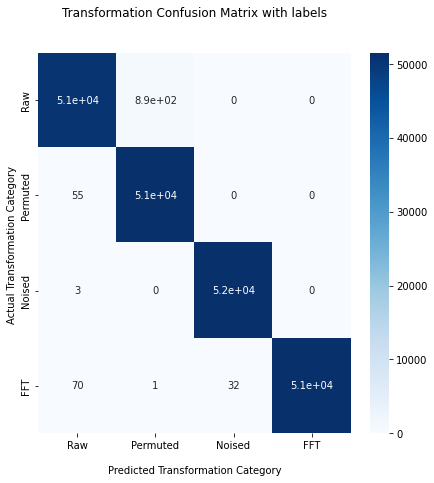

In [31]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
import seaborn as sns

y_pred = np.argmax(model.predict(x_test), axis=1)

cf_matrix = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
#cf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

print(cf_matrix)
#plot_confusion_matrix(conf_mat=cf_matrix, show_normed=True, figsize=(7,7))

fig, siz = plt.subplots(figsize=(7,7)) 
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', ax=siz)

ax.set_title('Transformation Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Transformation Category')
ax.set_ylabel('Actual Transformation Category ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Raw','Permuted', 'Noised', 'FFT'])
ax.yaxis.set_ticklabels(['Raw','Permuted', 'Noised', 'FFT'])

## Display the visualization of the Confusion Matrix.
plt.show()